# 📖 Introduction 📖

<div class="alert alert-block" style="font-size:20px; font-family:verdana; line-height:1.7em; border-radius:20px; padding:2em; background-color:#212021; border-color:white; color: #c4c2c4">
  <img src="https://www.investopedia.com/thmb/r0G8dCJxoUV5rsaTEuR8mUUymdI=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/terms_i_insurance_FINAL_-3556393b3bbf483e9bc8ad9b707641e4.jpg" style="float: right; margin-left: 20px; width: 300px;">
  </br></br>
  </br></br>
  </br></br>

</div>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import optuna
import lightgbm as lgb
from lightgbm import early_stopping
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
import holidays
import wbdata
import pycountry
import datetime

from fitter import Fitter
from scipy import stats
import shap

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
train_path = './data/train.csv'
test_path = './data/test.csv'

In [49]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [51]:
train_df = train_df.dropna()
train_df = train_df.drop_duplicates()

In [52]:
target = 'num_sold'

In [53]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

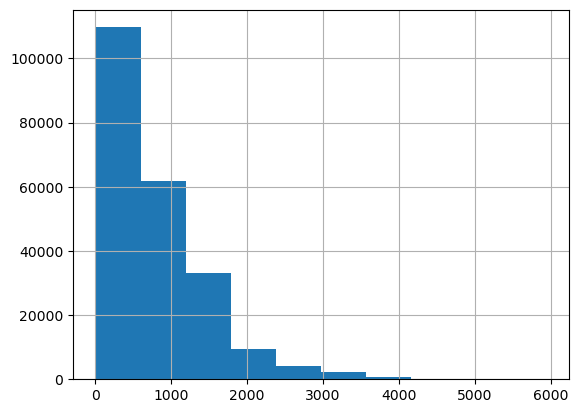

In [54]:
train_df['num_sold'].hist();

In [55]:
def convert_data(df):
  min_year = df['date'].dt.year.min()
  max_year = df['date'].dt.year.max()
  
  df['Year'] = df['date'].dt.year
  df['Quarter'] = df['date'].dt.quarter
  df['Month'] = df['date'].dt.month
  df['Day'] = df['date'].dt.day
  df['day_of_week'] = df['date'].dt.day_name()
  df['week_of_year'] = df['date'].dt.isocalendar().week

  df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 365.0)
  df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 365.0)
  
  df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
  df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
  
  df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
  df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
  
  df['Group'] = (df['Year'] - min_year)*48 + df['Month']*4 + df['Day'] // 7


In [56]:
convert_data(train_df)
convert_data(test_df)

In [57]:
train_df.head()

,id,date,country,store,product,num_sold,Year,Quarter,Month,Day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,Year_sin,Year_cos,Group
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,1,Friday,53,0.017213,0.999852,0.5,0.866025,0.0,1.0,4
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,1,Friday,53,0.017213,0.999852,0.5,0.866025,0.0,1.0,4
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,1,Friday,53,0.017213,0.999852,0.5,0.866025,0.0,1.0,4
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,1,Friday,53,0.017213,0.999852,0.5,0.866025,0.0,1.0,4
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,1,1,Friday,53,0.017213,0.999852,0.5,0.866025,0.0,1.0,4


In [58]:
def get_holiday_name(country_code, date_obj):
  country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
  return country_holiday.get(date_obj)

def get_country_code(country_name):
  try:
    country = pycountry.countries.get(name=country_name)
    return country.alpha_2
  except KeyError:
    print(f"Unknown Country: {country_name}")
    return None

def get_holiday_for_row(row):
  country_code = get_country_code(row["country"])
  if country_code is None:
    return "Unknown Country"
  
  try:
    date_obj = row["date"]
  except ValueError:
    print(f"Invalid Date: {row['date']}")
    return "Invalid Date"

  return get_holiday_name(country_code, date_obj)


In [59]:
train_df["holidays_name"] = train_df.apply(get_holiday_for_row, axis=1)
test_df["holidays_name"] = test_df.apply(get_holiday_for_row, axis=1)

In [60]:
countries = train_df['country'].unique()
start_date = train_df['date'].min()
end_date = test_df['date'].max()

In [61]:
def get_gdp_data(country_code, start_date, end_date):
  df = wbdata.get_dataframe(
    {"NY.GDP.MKTP.KD.ZG": "GDP"},
    country=country_code,
    date=(start_date, end_date)
  )
  return df

In [62]:
gdp_map = {}

for country in countries:
  country_code = get_country_code(country)
  gdp_map[country] = get_gdp_data(country_code, start_date, end_date)

In [63]:
def fill_gdp(row):
  country_name = row['country']  
  year = str(row['date'].year)
  
  gdp = gdp_map[country_name].loc[year]
  
  return gdp

In [64]:
train_df['GDP'] = train_df.apply(fill_gdp, axis=1)
test_df['GDP'] = test_df.apply(fill_gdp, axis=1)

In [65]:
train_df['GDP'].describe()

count    221259.000000
mean          2.493254
std           2.915379
min          -3.125239
25%           0.885668
50%           2.325814
75%           3.935540
max          14.519750
Name: GDP, dtype: float64

In [66]:
population_map = {}

for country in countries:
  country_code = get_country_code(country)
  population_map[country] = wbdata.get_dataframe(
    {'SP.POP.TOTL': 'total_population'},
    date=(start_date, end_date),
    country=country_code
  )

In [67]:
def fill_population(row):
  country_name = row['country']  
  year = str(row['date'].year)
  
  population = population_map[country_name].loc[year]
  
  return population

In [68]:
train_df['population'] = train_df.apply(fill_population, axis=1)
test_df['population'] = test_df.apply(fill_population, axis=1)

In [69]:
train_df = train_df.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])

In [70]:
train_df = train_df.drop('id', axis = 1, errors='ignore')
numerical_features = list(train_df.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
categorical_features = list(train_df.select_dtypes(include=['object']).columns)

numerical_features_test = list(test_df.select_dtypes(exclude=['object']).columns.difference(['id']))
categorical_features_test = list(test_df.select_dtypes(include=['object']).columns)

print('numerical_features:', numerical_features)
print('categorical_features:', categorical_features)

numerical_features: ['Day', 'GDP', 'Group', 'Month', 'Quarter', 'Year', 'Year_cos', 'Year_sin', 'day_cos', 'day_sin', 'month_cos', 'month_sin', 'population', 'week_of_year']
categorical_features: ['country', 'store', 'product', 'day_of_week', 'holidays_name']


In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   country        221259 non-null  object 
 1   store          221259 non-null  object 
 2   product        221259 non-null  object 
 3   num_sold       221259 non-null  float64
 4   Year           221259 non-null  int32  
 5   Quarter        221259 non-null  int32  
 6   Month          221259 non-null  int32  
 7   Day            221259 non-null  int32  
 8   day_of_week    221259 non-null  object 
 9   week_of_year   221259 non-null  UInt32 
 10  day_sin        221259 non-null  float64
 11  day_cos        221259 non-null  float64
 12  month_sin      221259 non-null  float64
 13  month_cos      221259 non-null  float64
 14  Year_sin       221259 non-null  float64
 15  Year_cos       221259 non-null  float64
 16  Group          221259 non-null  int32  
 17  holidays_name  6948 non-null    ob

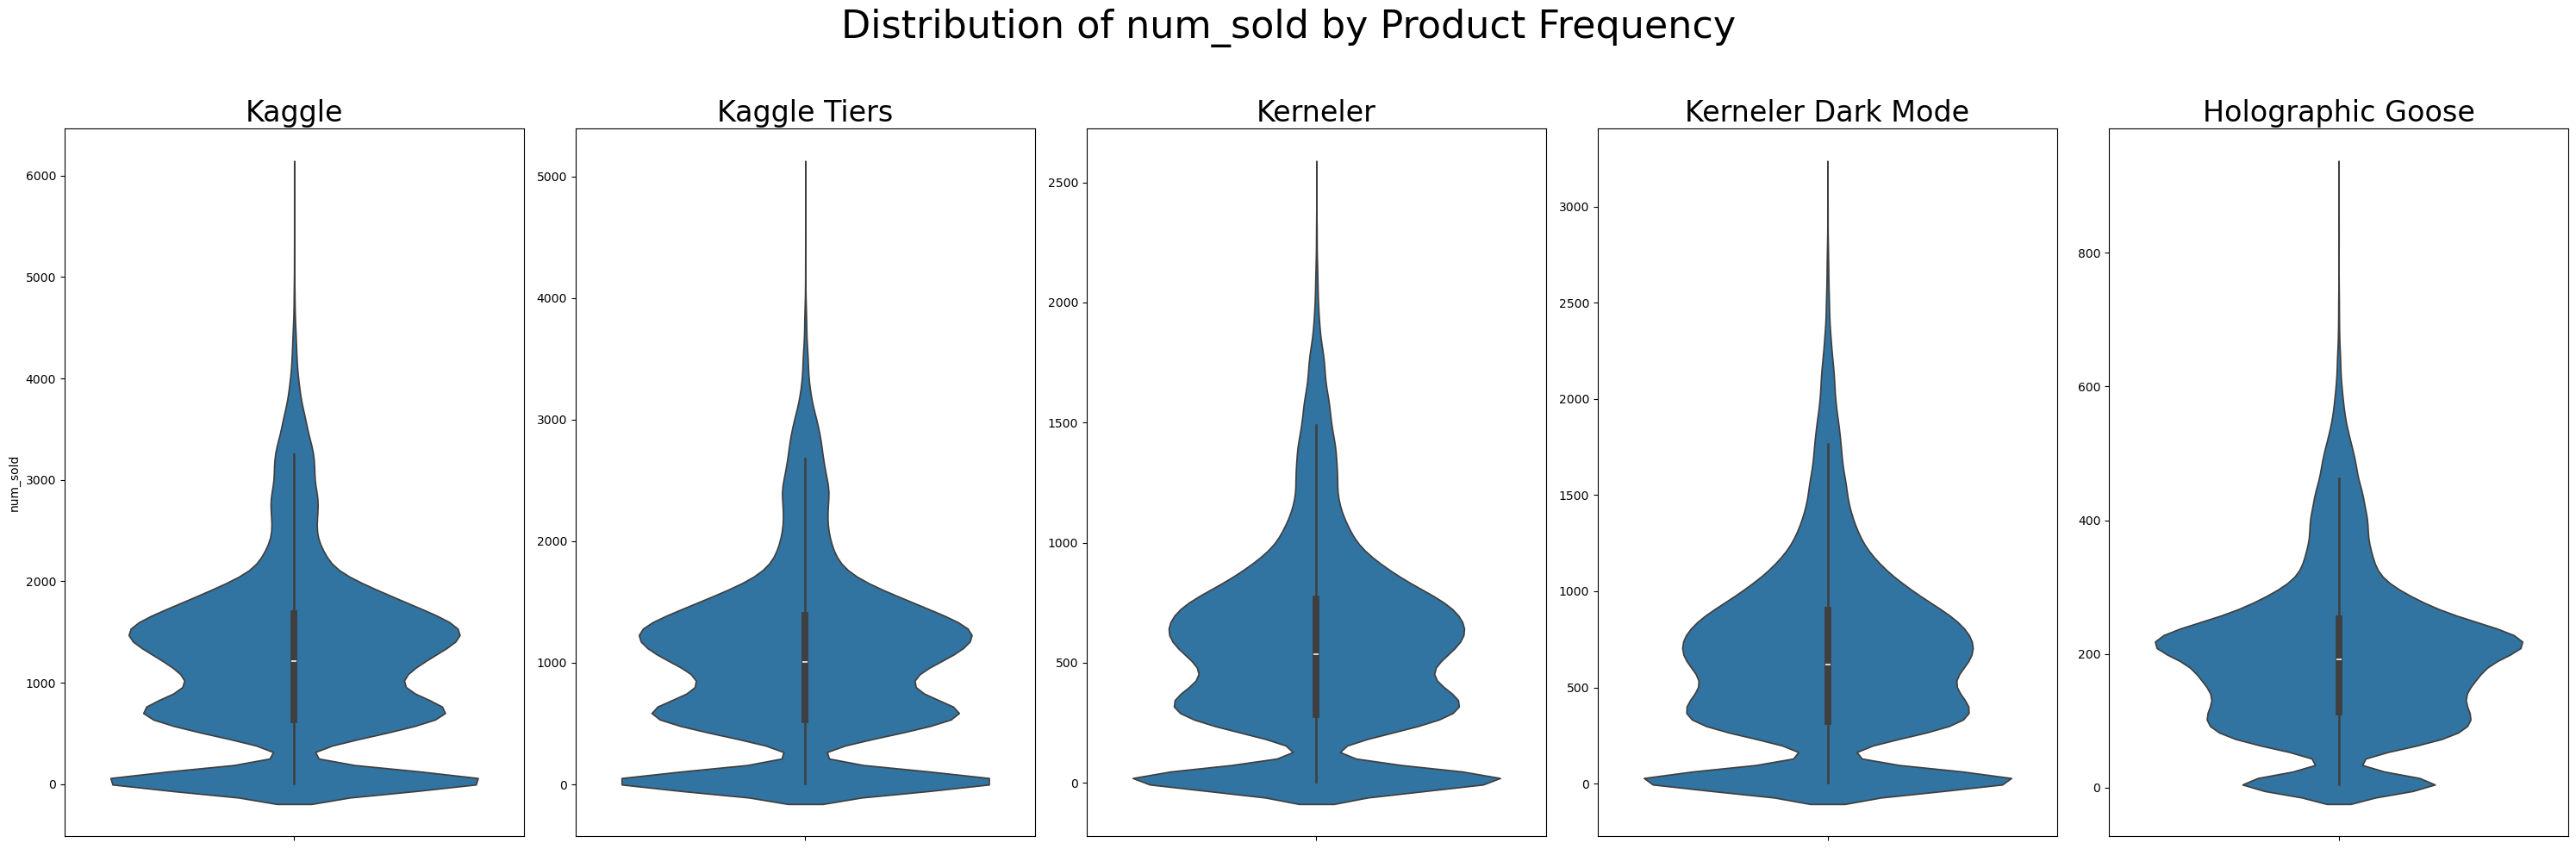

In [72]:
product = train_df['product'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(product), figsize=(6 * len(product), 10))

if len(product) == 1:
  axes = [axes]

for i, category in enumerate(product):
  sns.violinplot(
    data=train_df[train_df['product'] == category],
    y=target,
    ax=axes[i],
  )
  axes[i].set_title(f'{category}', fontsize=24)
  axes[i].set_ylabel('' if i > 0 else target)

fig.suptitle('Distribution of num_sold by Product Frequency', fontsize=32)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [73]:
def plot_two_features(column1, column2):
  values1 = train_df[column1].unique()
  values2 = train_df[column2].unique()

  fig, axes = plt.subplots(
    nrows=len(values2), 
    ncols=len(values1), 
    figsize=(6 * len(values1), 4 * len(values2))
  )

  axes = np.atleast_2d(axes)

  for i, country in enumerate(values2):
    for j, store in enumerate(values1):
      ax = axes[i, j]
      data = train_df[(train_df[column2] == country) & (train_df[column1] == store)][target]
      
      ax.hist(data, bins=20, alpha=0.7, color='blue', edgecolor='black')
      ax.set_title(f'{country} - {store}', fontsize=12)
      ax.set_xlabel('' if i < len(values2) - 1 else target)
      ax.set_ylabel('' if j > 0 else 'Frequency')

  fig.suptitle(f'Distribution of {target} by {column1} and {column2}', fontsize=24)

  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

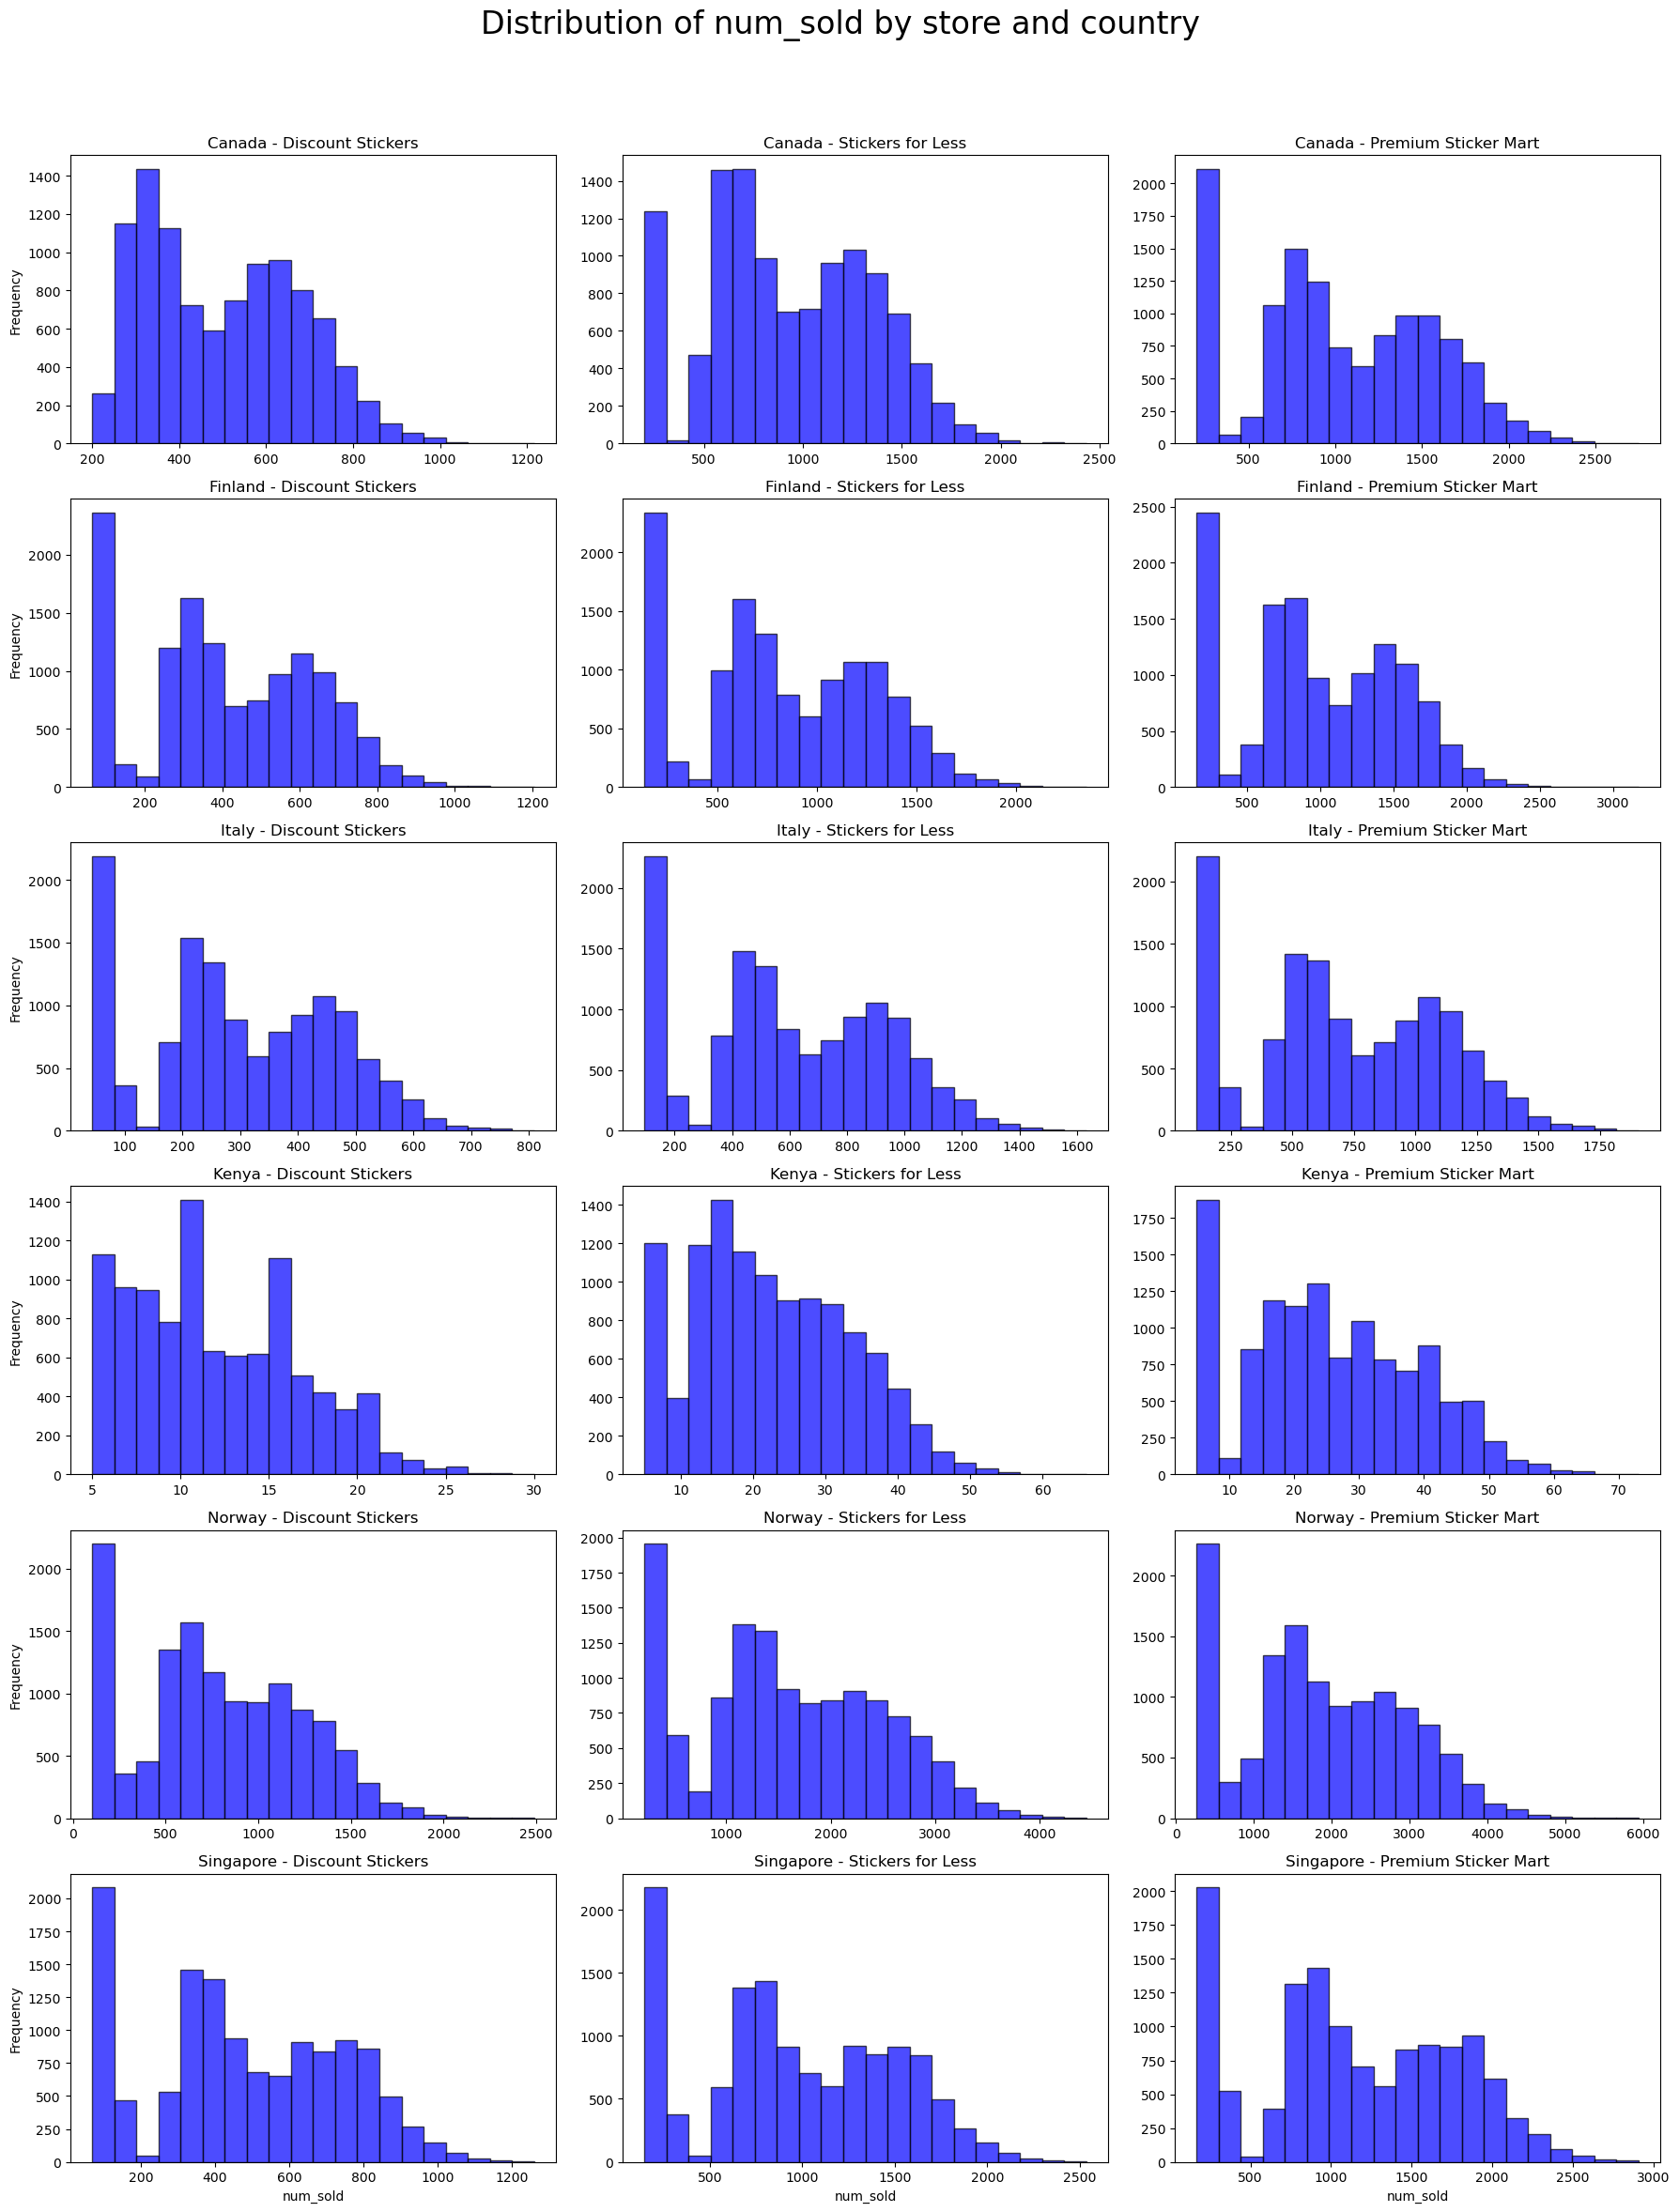

In [74]:
plot_two_features('store', 'country')

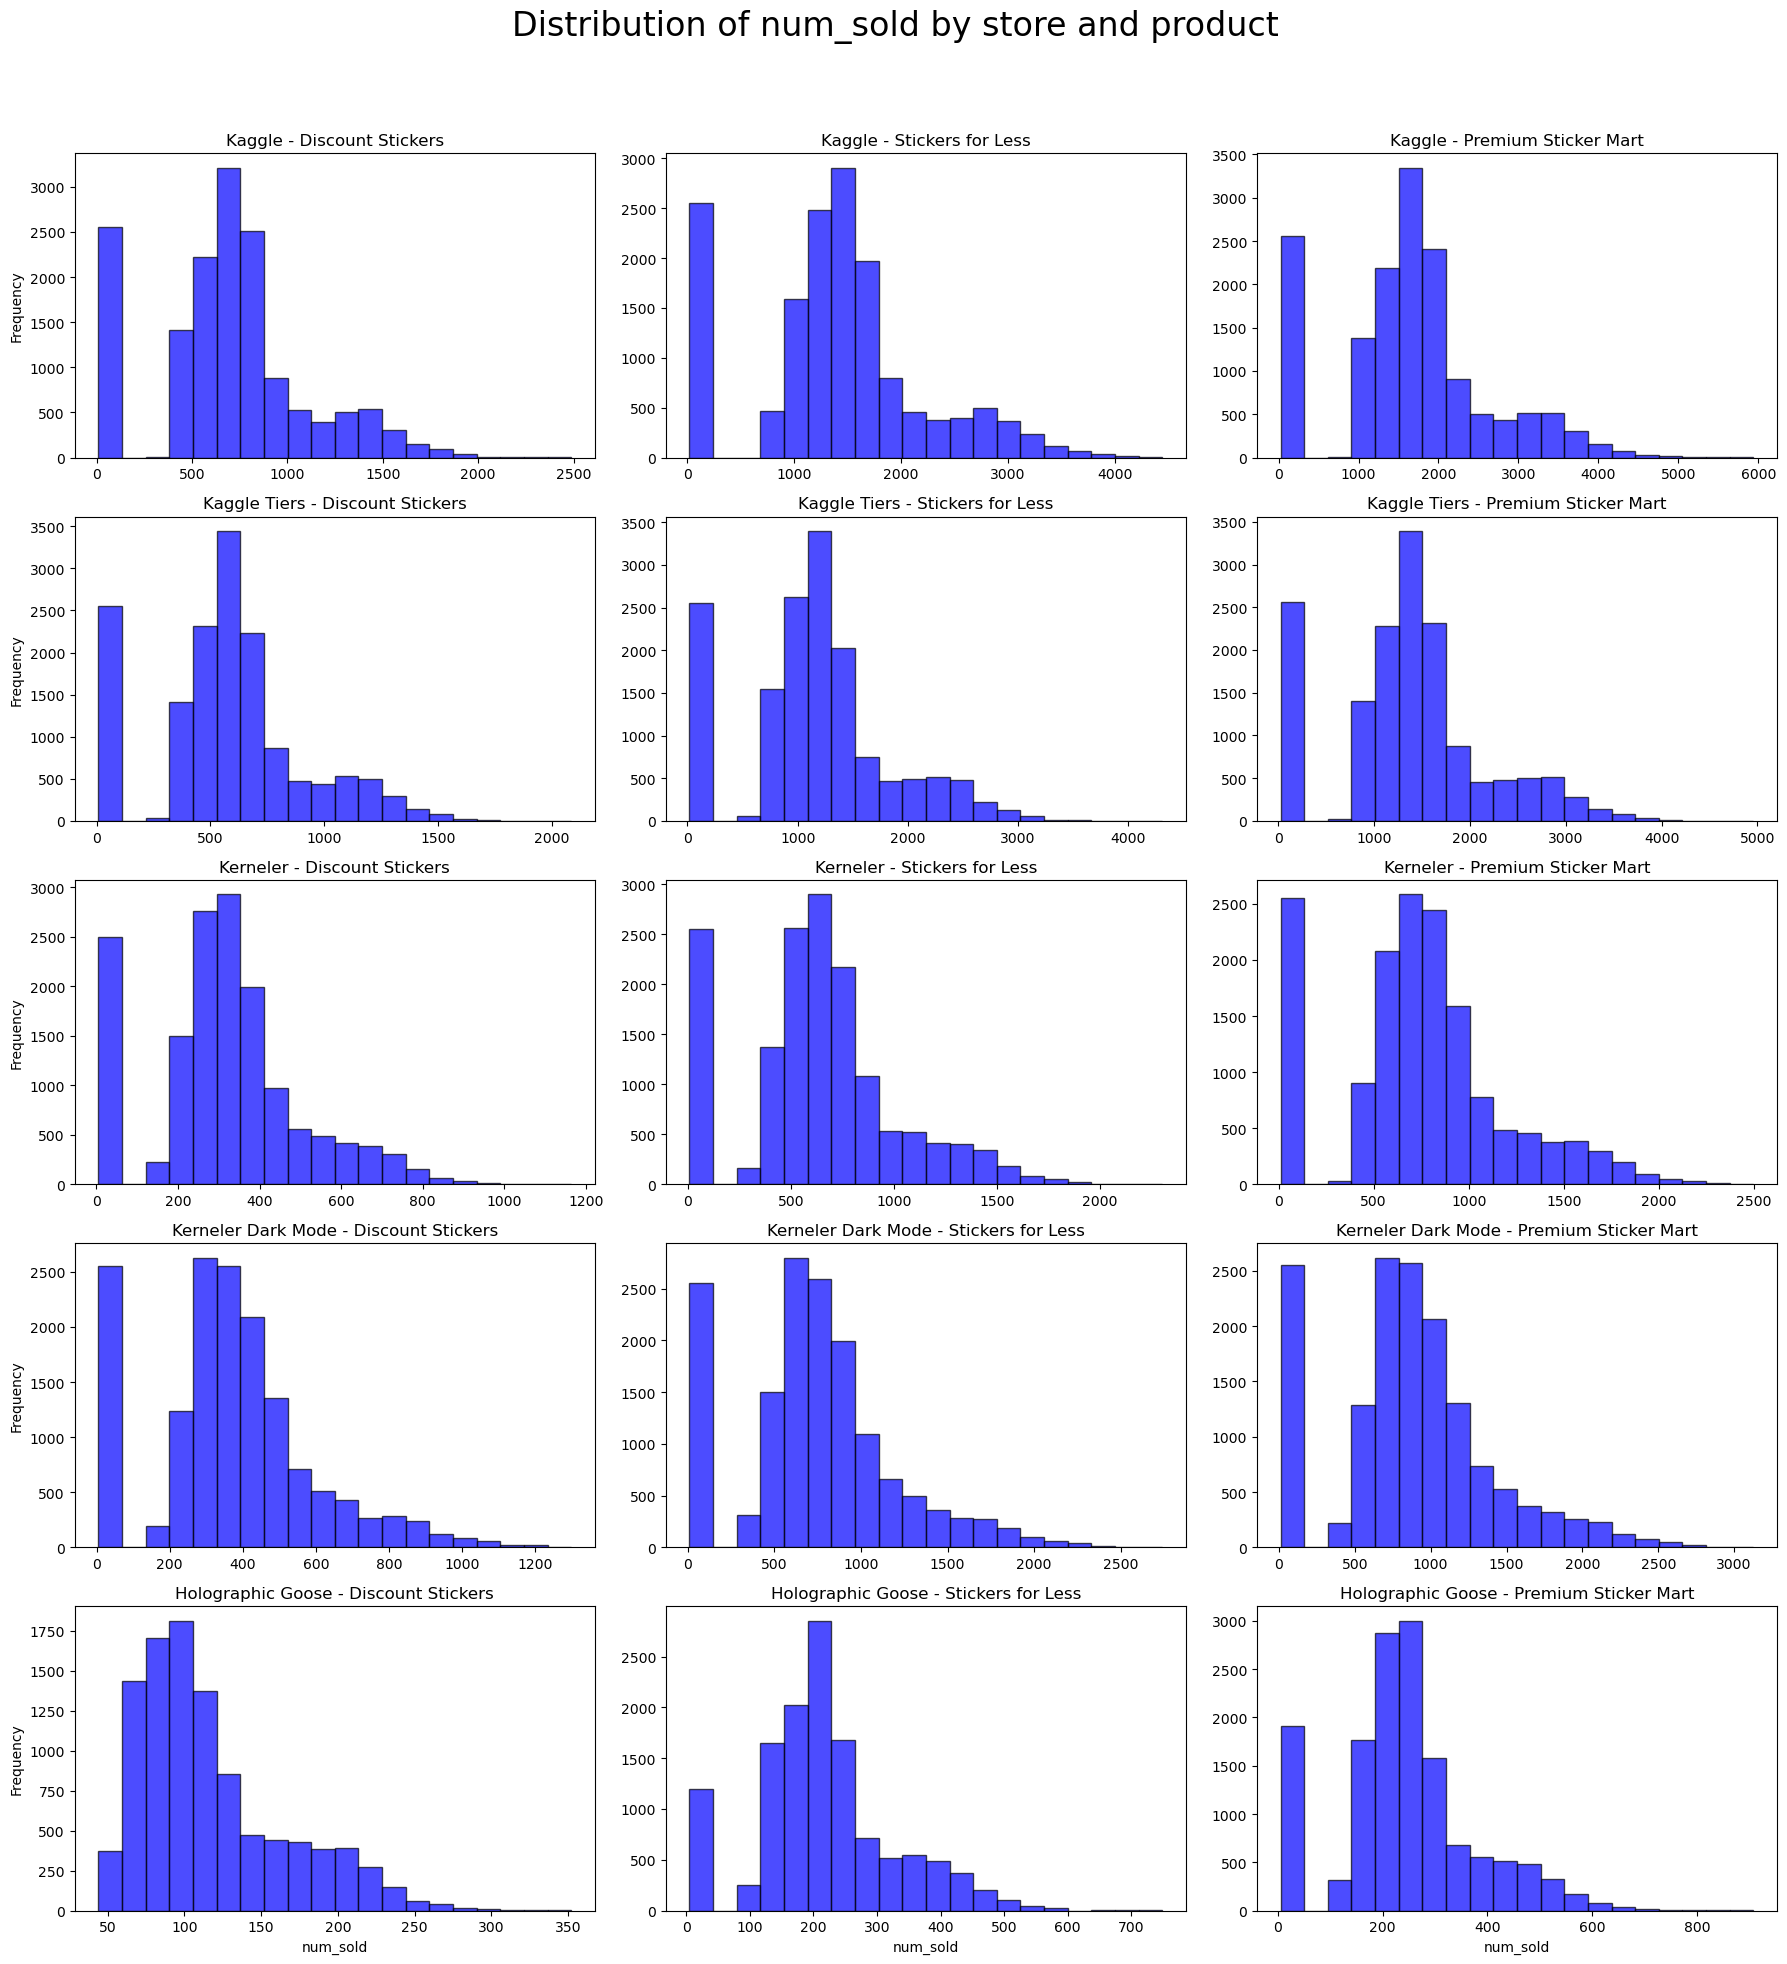

In [75]:
plot_two_features('store', 'product')

In [76]:
train_df.columns

Index(['country', 'store', 'product', 'num_sold', 'Year', 'Quarter', 'Month',
       'Day', 'day_of_week', 'week_of_year', 'day_sin', 'day_cos', 'month_sin',
       'month_cos', 'Year_sin', 'Year_cos', 'Group', 'holidays_name', 'GDP',
       'population'],
      dtype='object')

In [77]:
def pie_chart(column1, column2):
  values = train_df[column1].unique()

  n_values = len(values)
  n_cols = 2
  n_rows = (n_values + n_cols - 1) // n_cols
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

  axes = axes.flatten()

  for i, status in enumerate(values):
    subset = train_df[train_df[column1] == status]
    status_label = status

    subset_counts = subset[column2].value_counts()

    axes[i].pie(subset_counts, labels=subset_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{column2} Distribution for {status_label}')
    
  for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

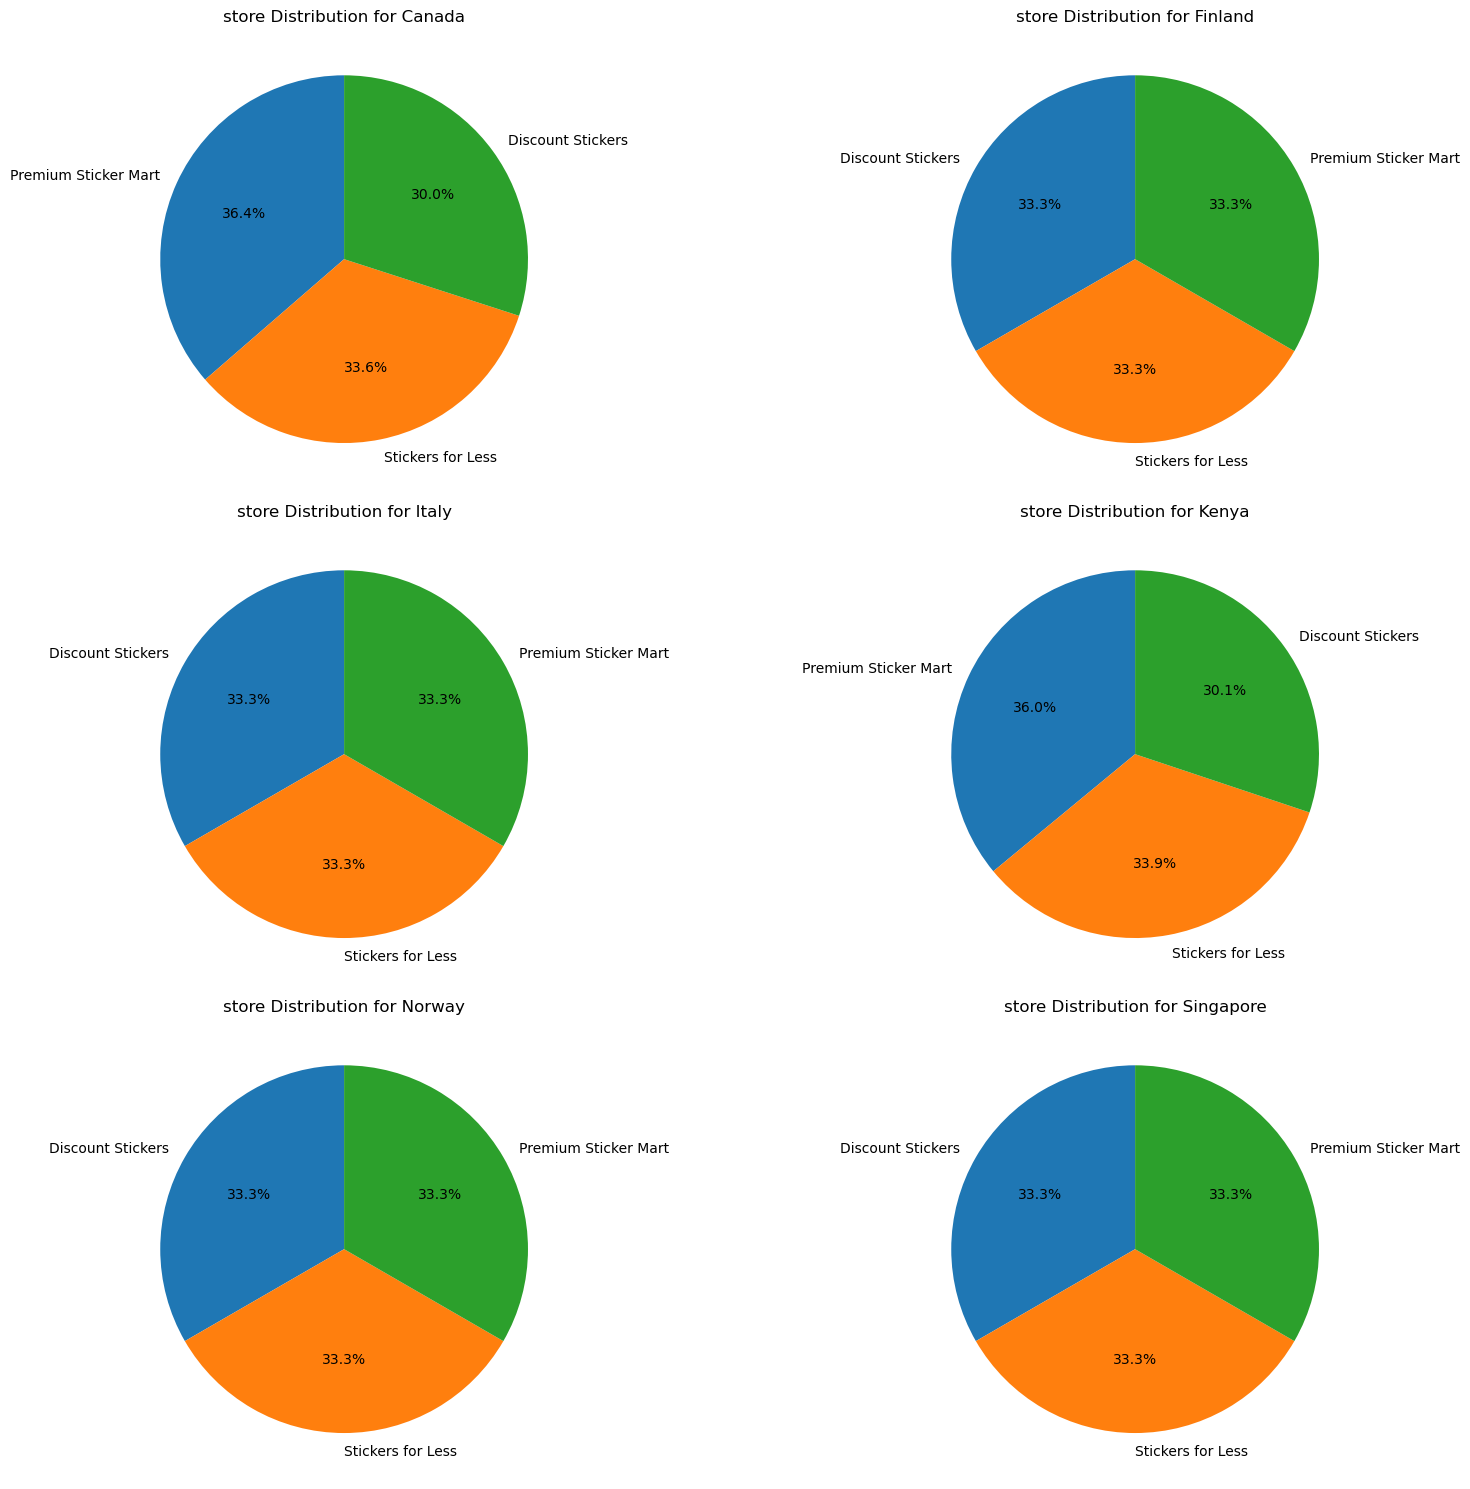

In [78]:
pie_chart('country', 'store')

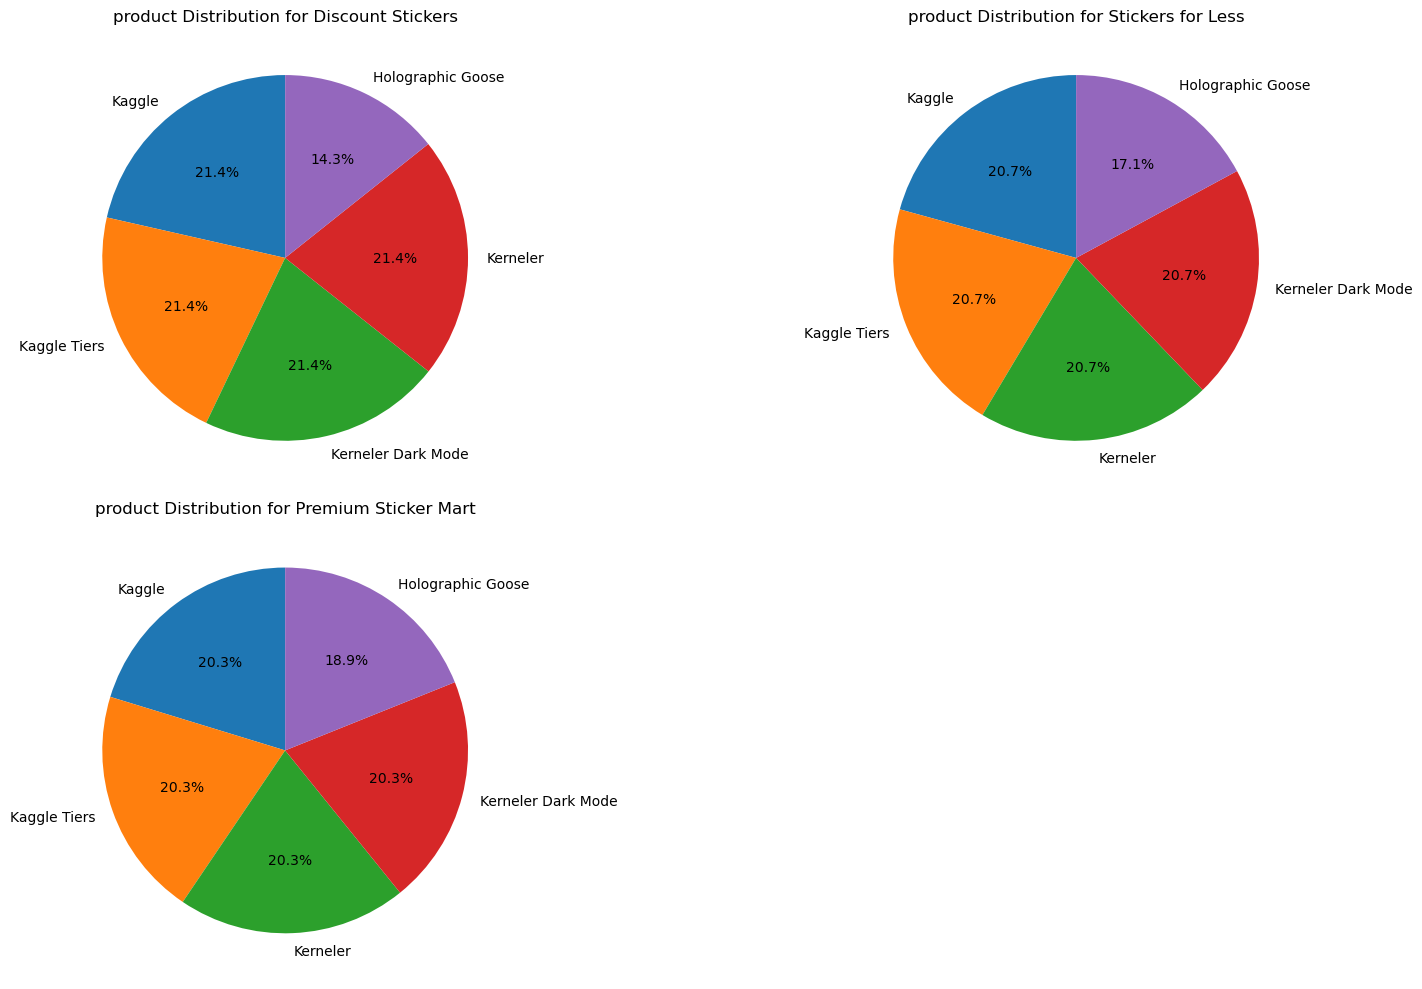

In [79]:
pie_chart('store', 'product')

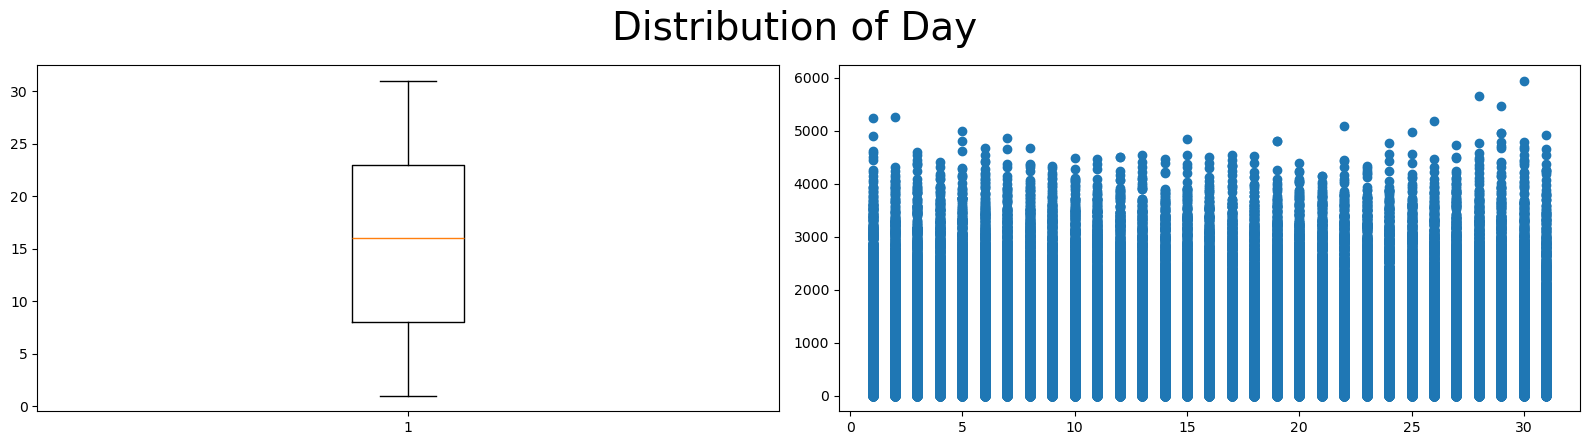

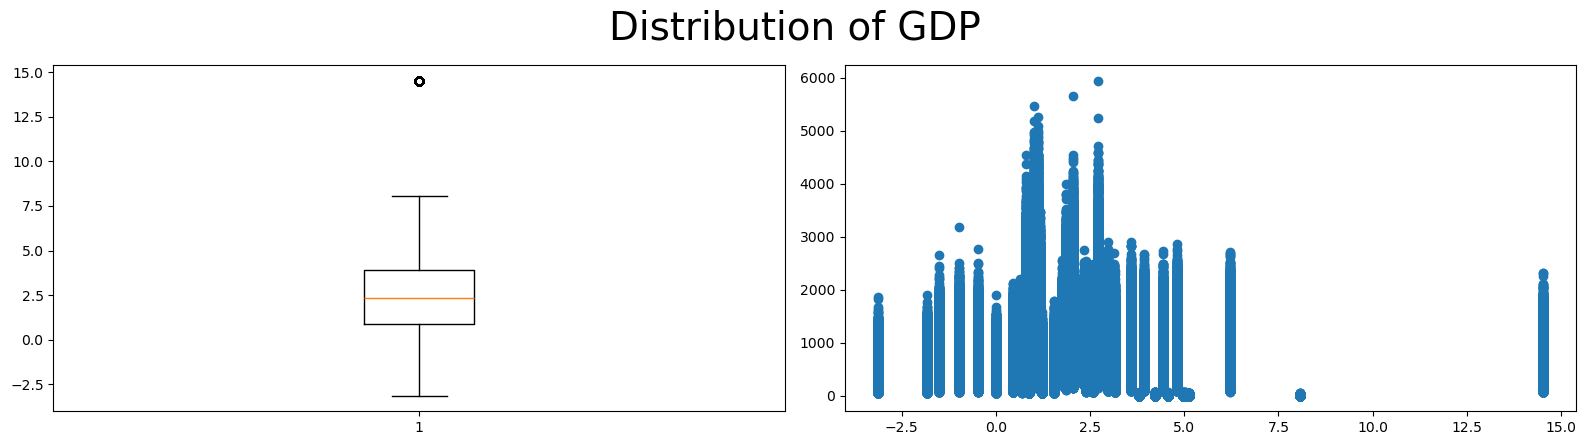

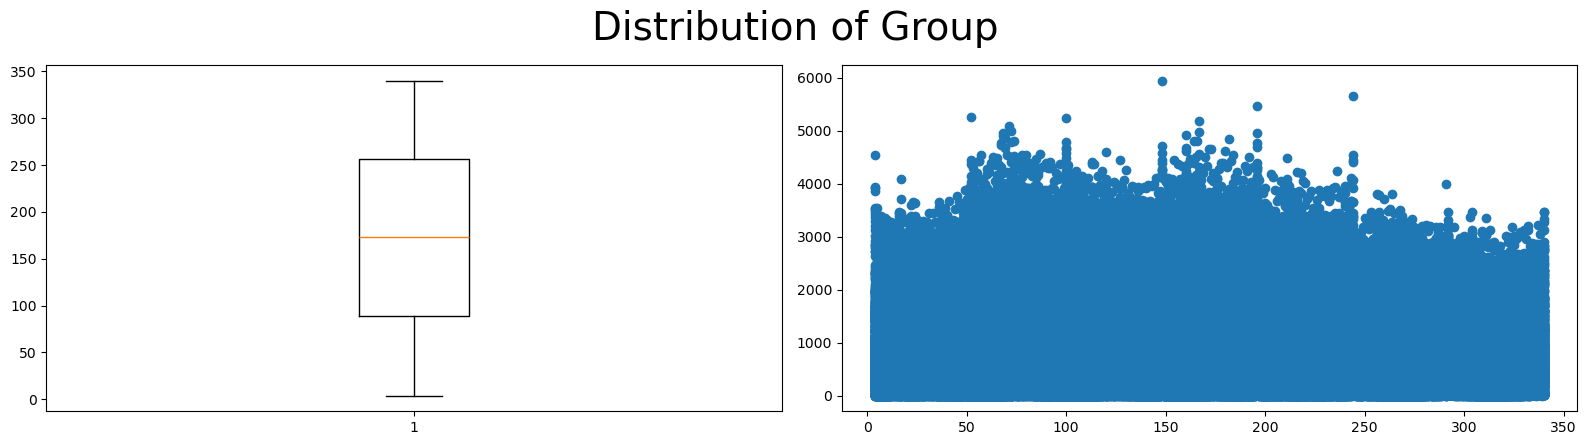

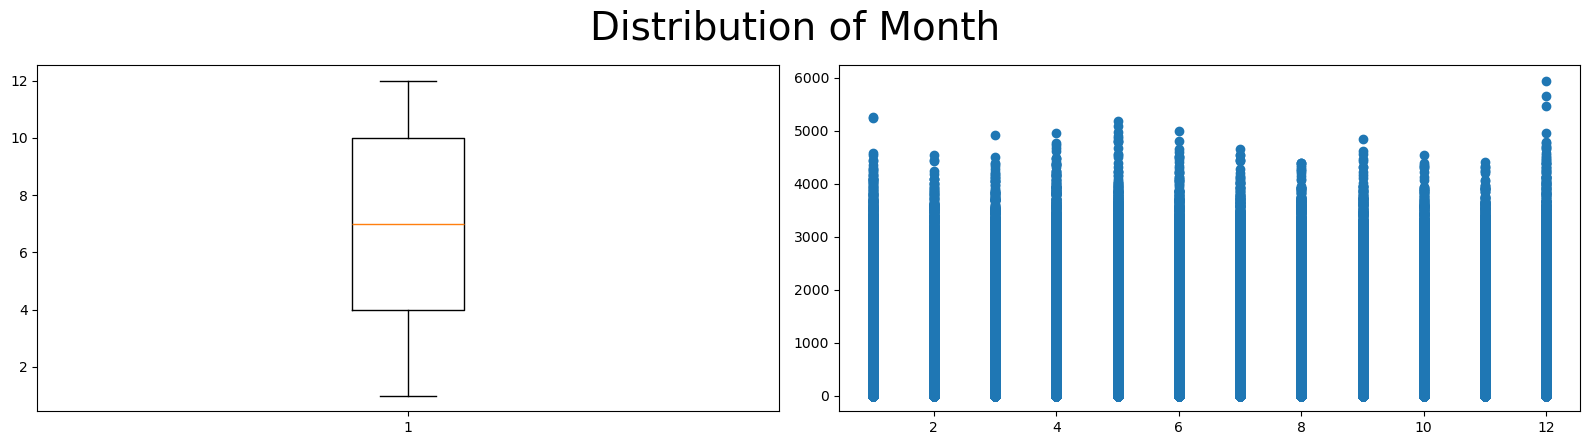

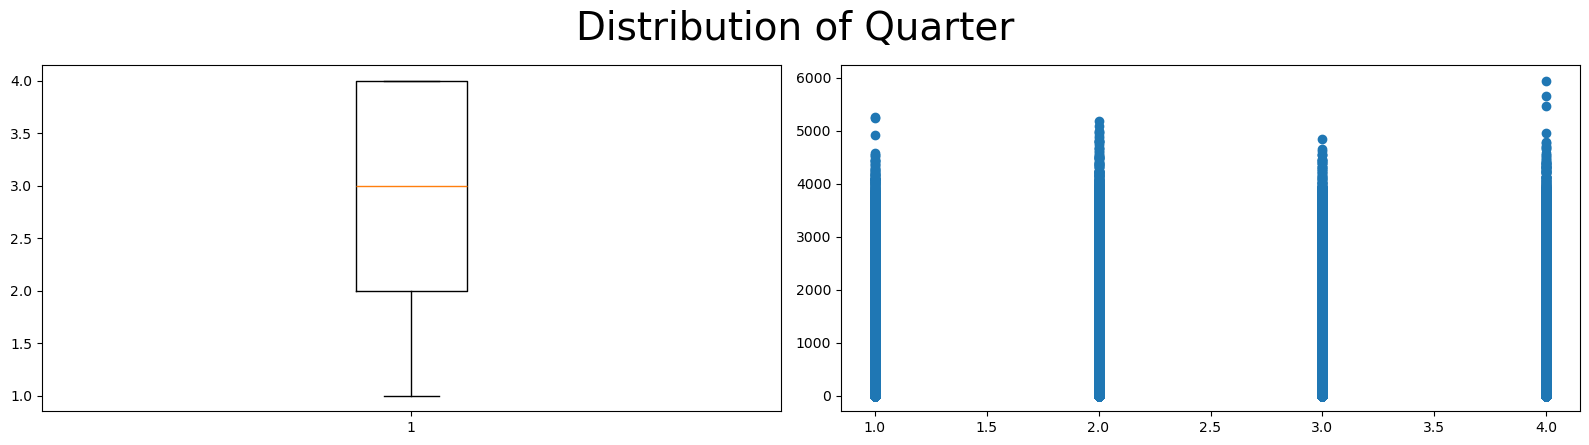

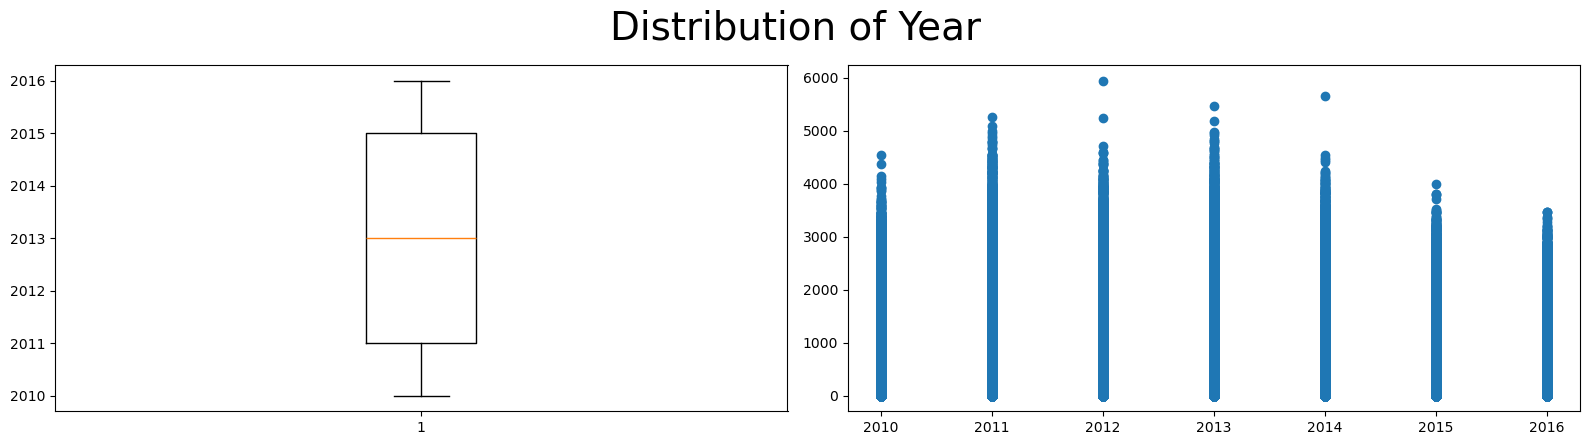

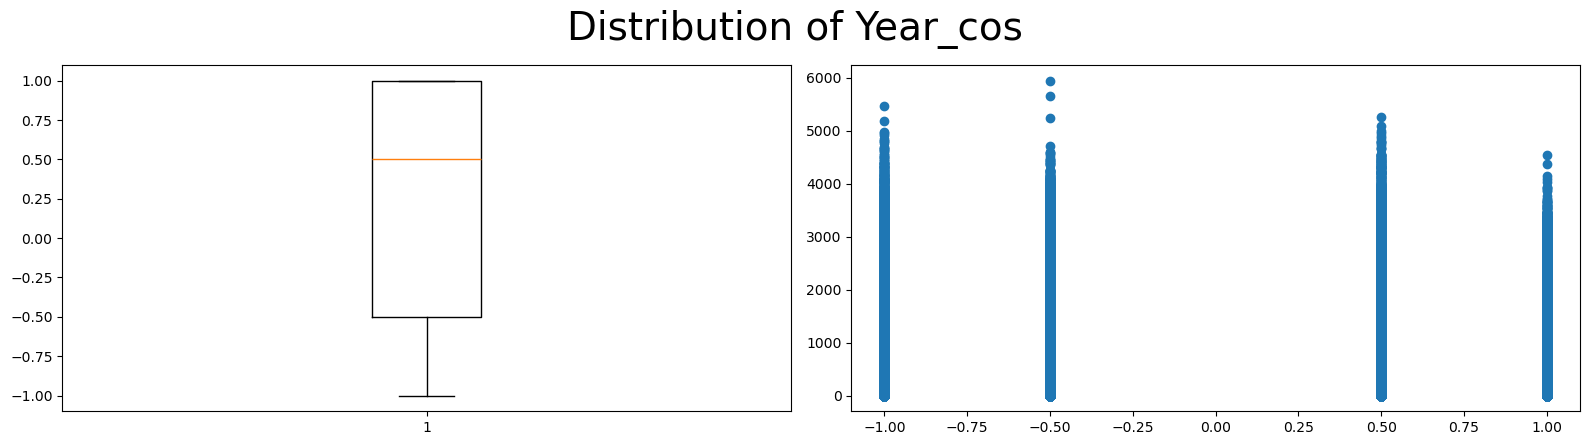

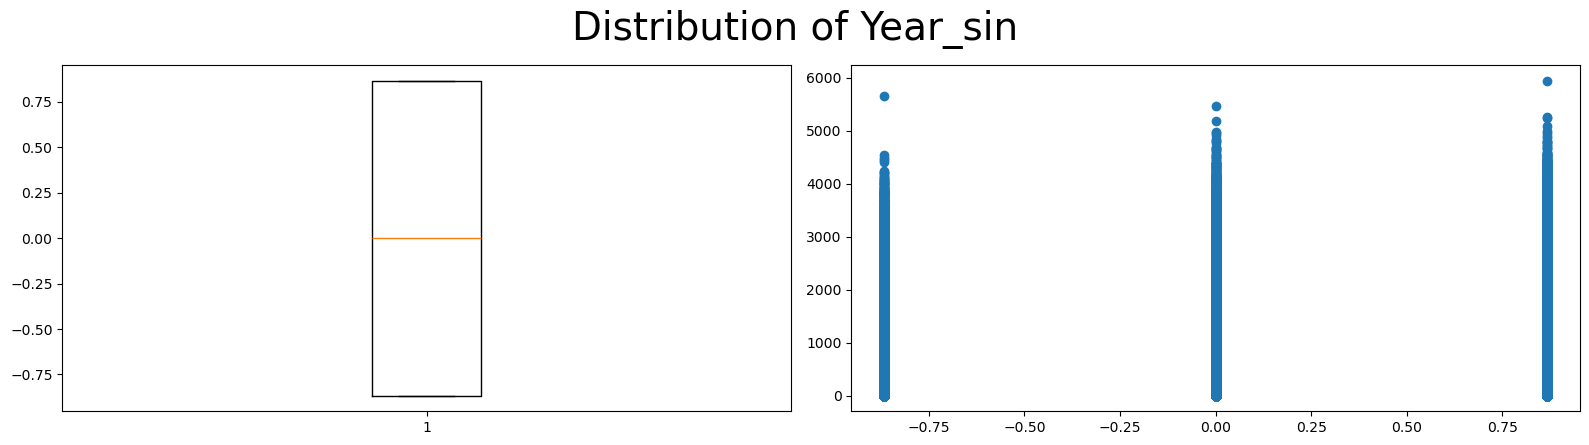

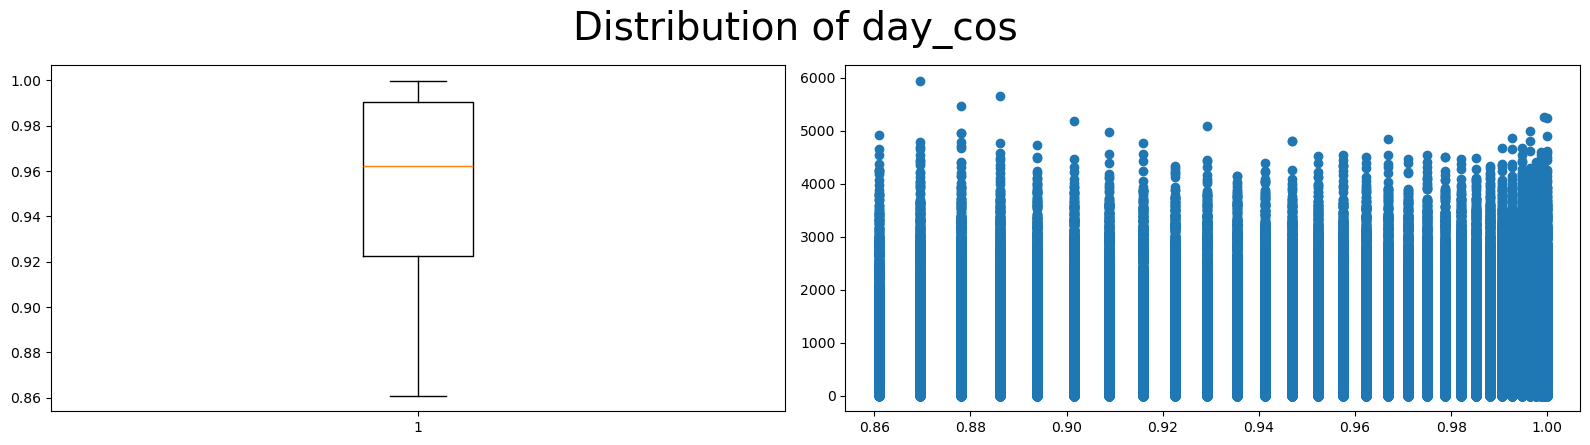

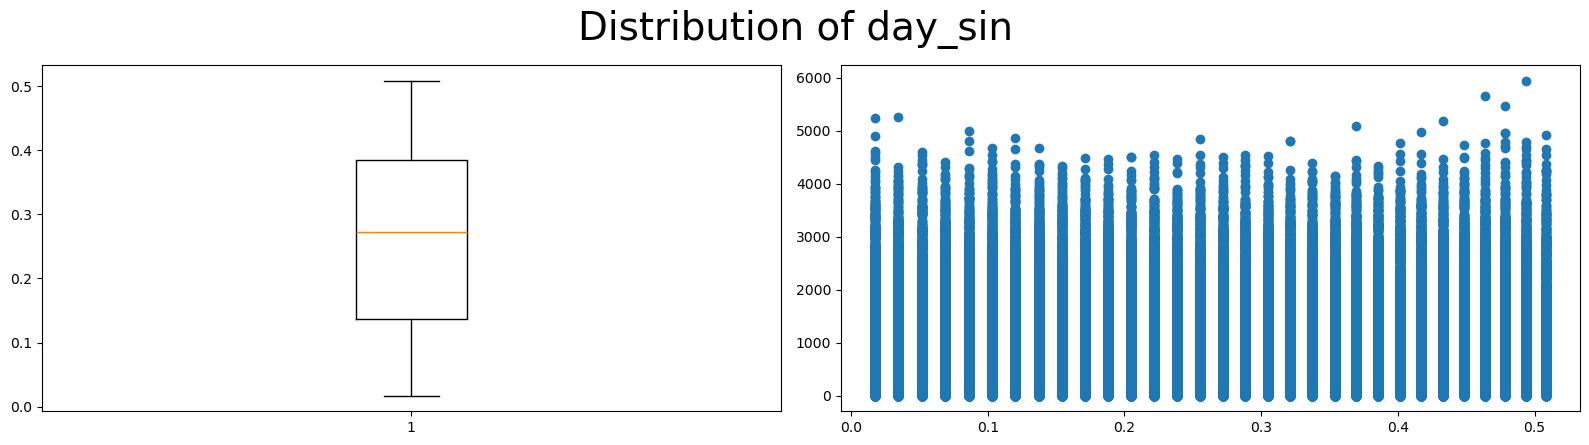

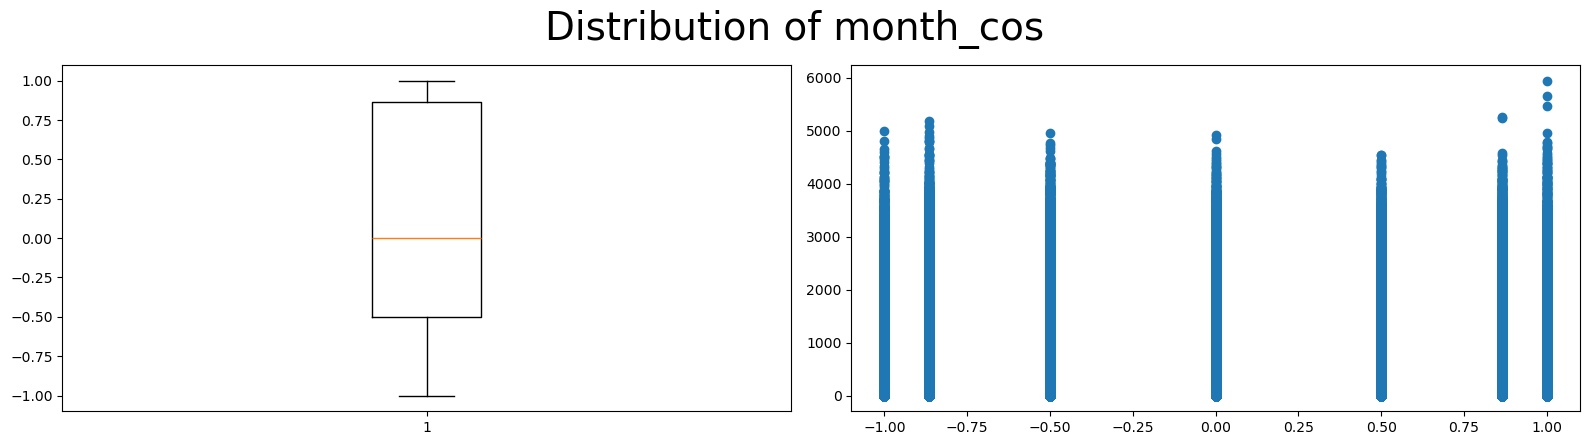

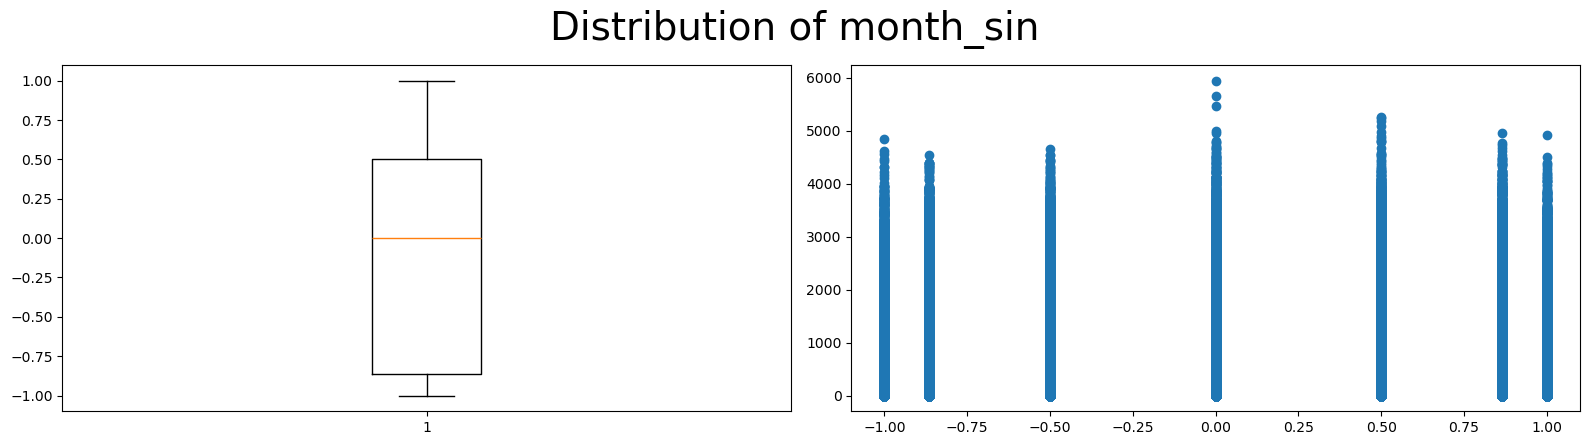

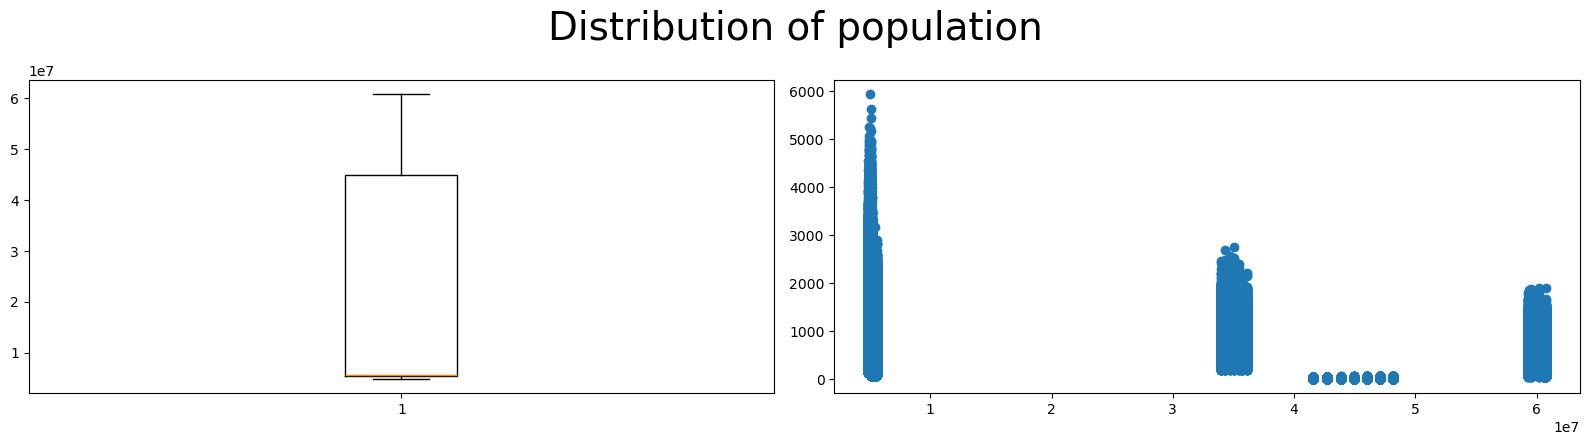

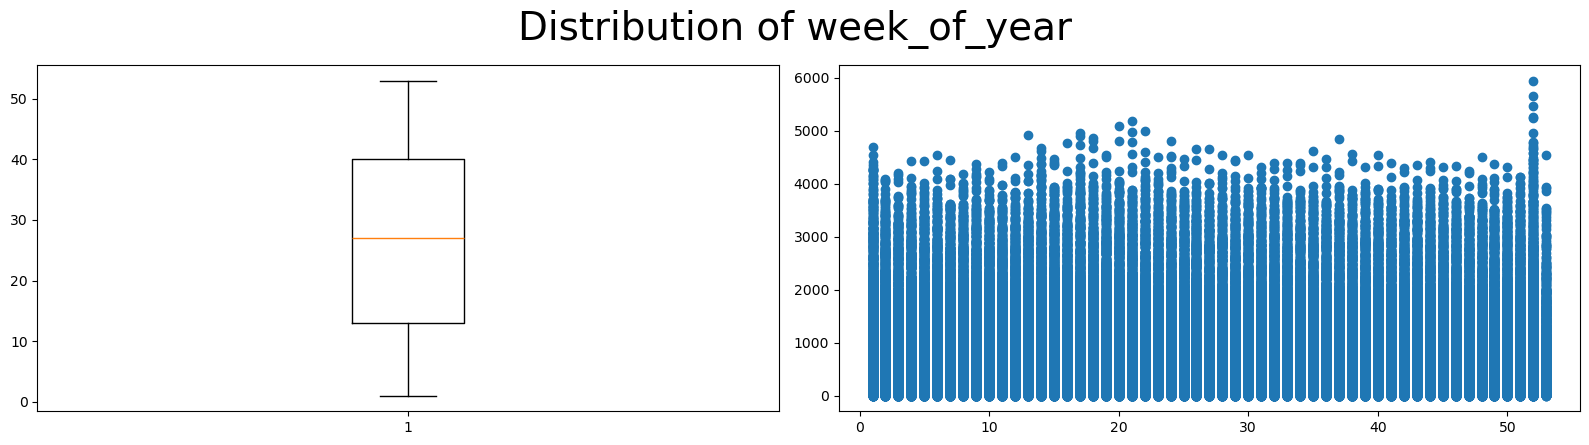

In [80]:
for col in numerical_features:
  fig, axs = plt.subplots(1, 2, figsize=(16, 4))
  ax = axs.flatten()

  ax[0].boxplot(train_df[col].dropna())
  
  plt.scatter(train_df[col], y=train_df[target])

  plt.tight_layout()
  plt.suptitle(f"Distribution of {col}", y=1.1, size=28)
  plt.show();

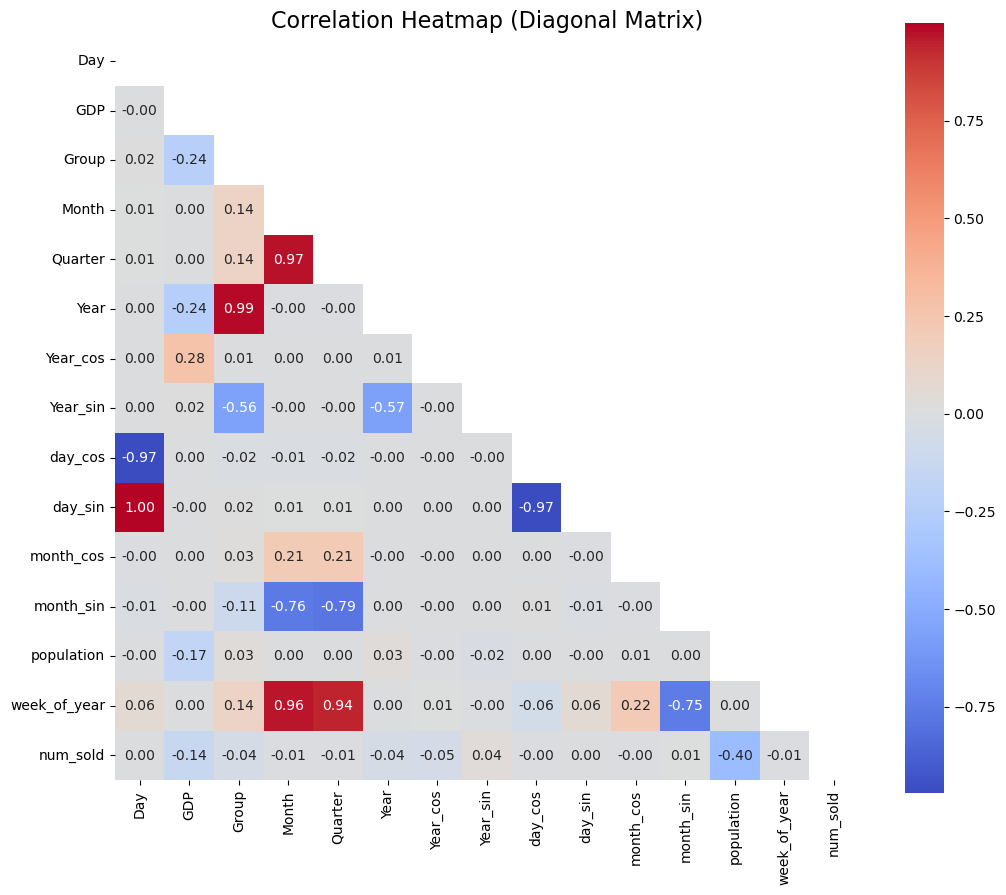

In [81]:
columns = numerical_features.copy() + [target]
correlation_matrix = train_df[columns].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=np.triu(np.ones(correlation_matrix.shape)))

plt.title("Correlation Heatmap (Diagonal Matrix)", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

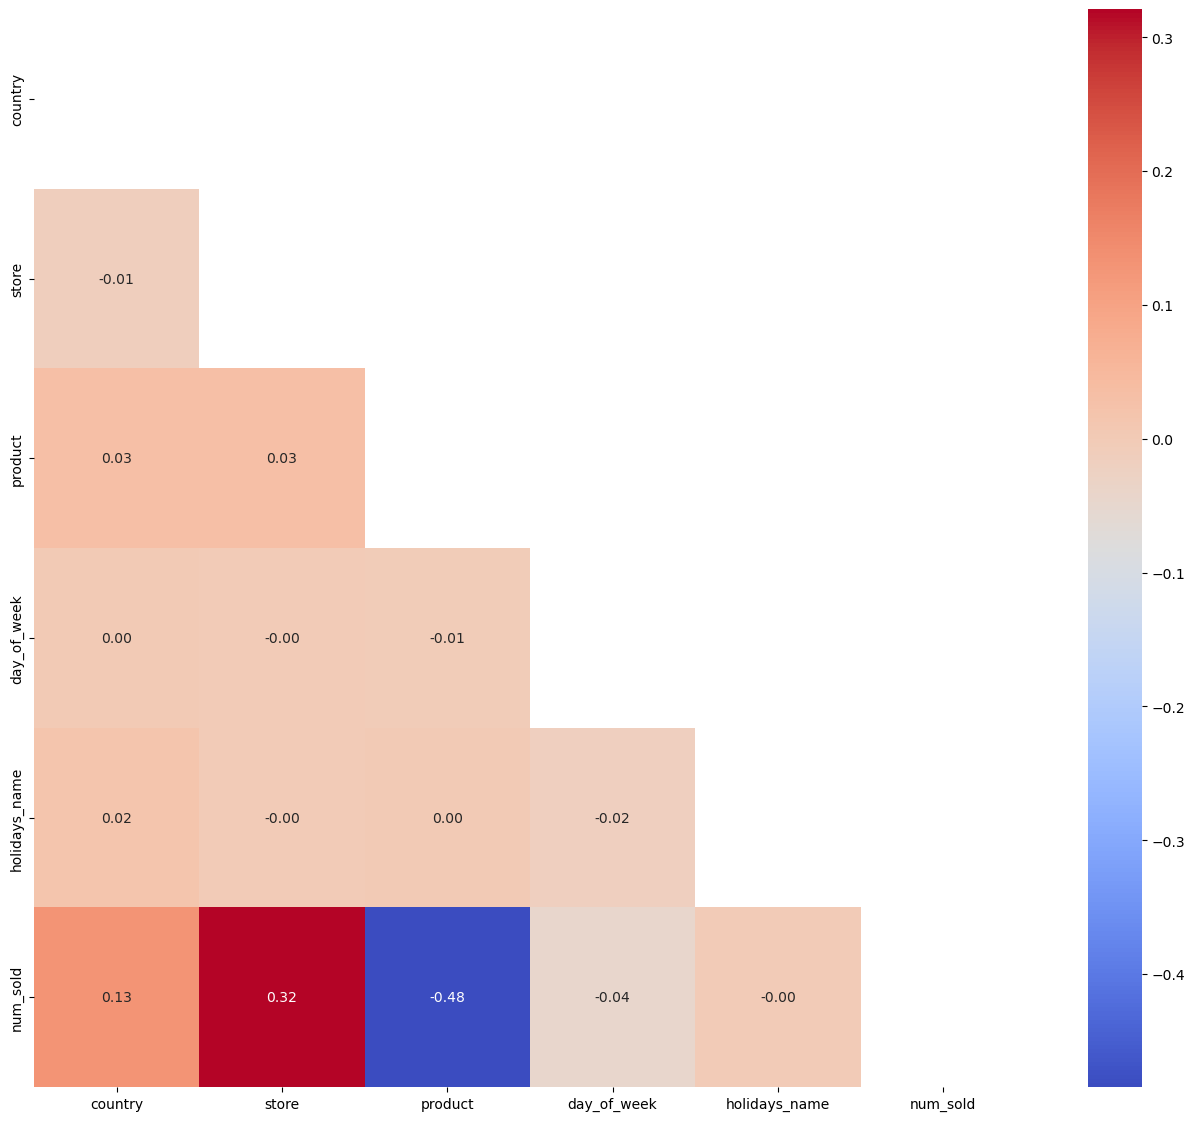

In [82]:
train_cr = train_df.copy()

for col in categorical_features:
    train_cr[col], _ = train_cr[col].factorize()

columns = categorical_features.copy() + [target]

cor_mat = train_cr[columns].corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(16, 14))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()

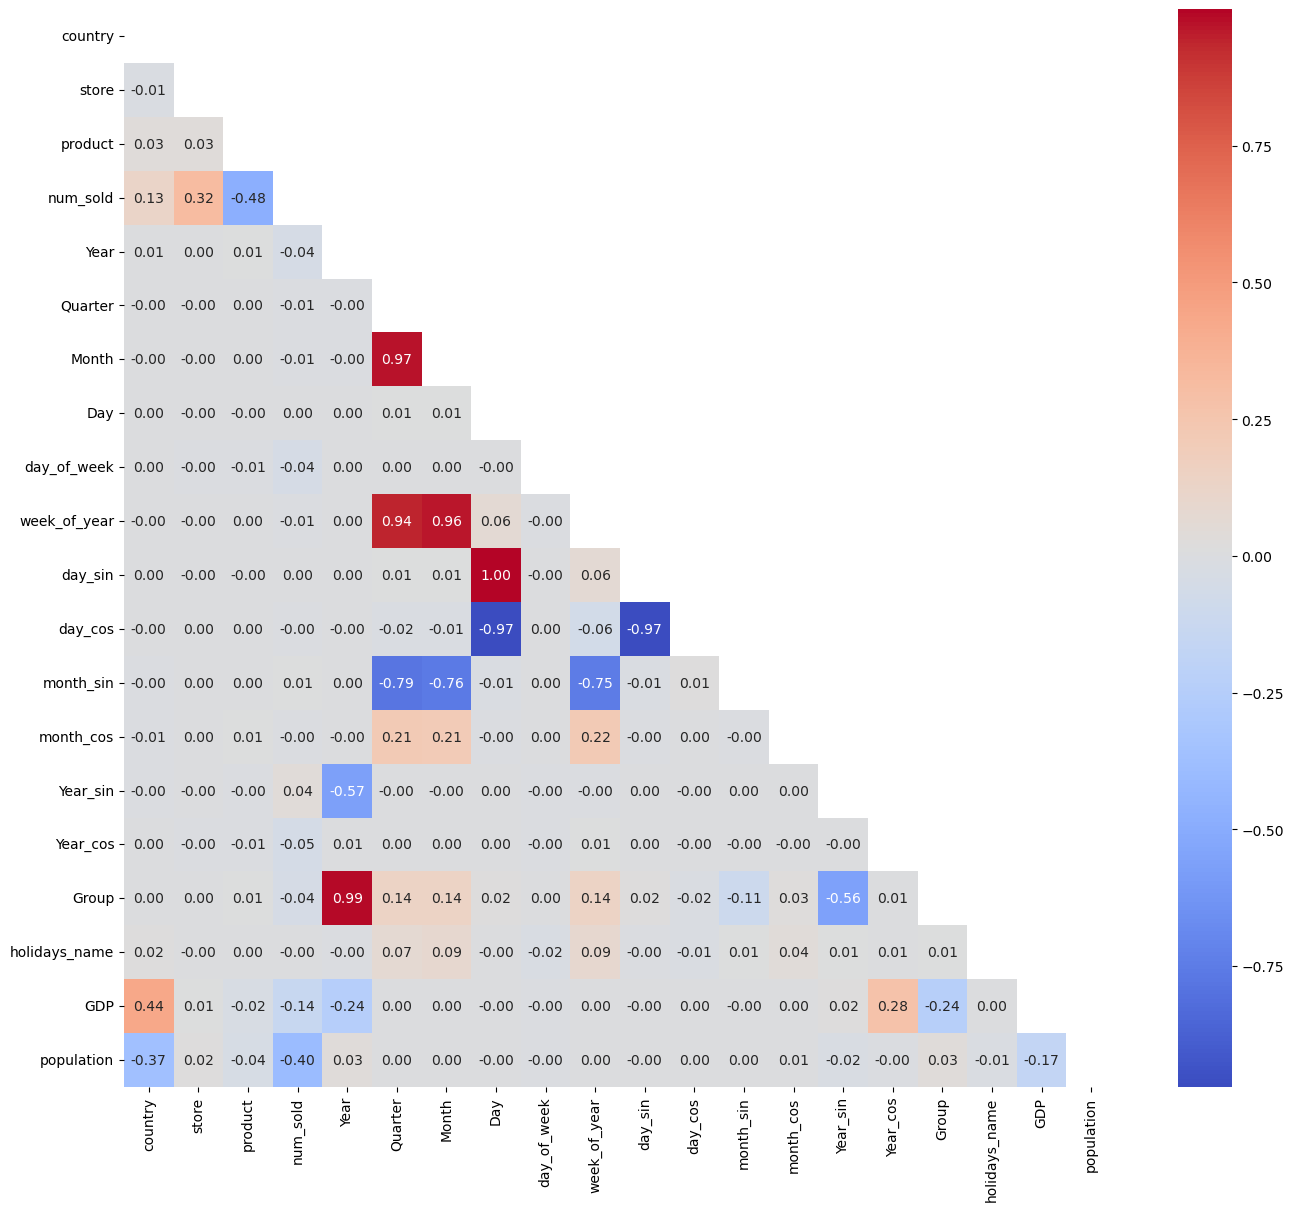

In [83]:
train_cr = train_df.copy()

for col in categorical_features:
    train_cr[col], _ = train_cr[col].factorize()

cor_mat = train_cr.corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(16, 14))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [84]:
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in categorical_features}

# Apply LabelEncoder to each categorical column
for col in categorical_features:
  combined_data = pd.concat([train_df[col], test_df[col]])
  le = LabelEncoder()
  le.fit(combined_data)
  train_df[col] = le.transform(train_df[col])
  test_df[col] = le.transform(test_df[col])

In [98]:
X = train_df.drop(['id', 'date', 'num_sold', 'population', 'GPD'], axis=1, errors='ignore')
y = train_df['num_sold']
X_test = test_df.drop(['id', 'date', 'num_sold', 'population', 'GPD'], axis=1, errors='ignore')
y_log = np.log1p(y)

In [99]:
def mape(y_true, y_pred):
  return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))

In [101]:
def objective(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 300, 500),
    'objective': 'regression',
    'metric': 'mape',
    'boosting_type': 'dart',
    'num_leaves': trial.suggest_int('num_leaves', 50, 150),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 5, 12),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
    'max_depth': trial.suggest_int('max_depth', -1, 12),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 10.0, log=True),
    'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.001, 0.1),
    'seed' : 42,
    'verbose':-1
  }
  
  model = lgb.LGBMRegressor(**params)
  folds = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = []

  for train_idx, val_idx in folds.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

    model.fit(
      X_train, y_train,
      eval_set=[(X_val, y_val)],
      eval_metric='mape',
      callbacks=[early_stopping(100)]
    )
    preds = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, preds)
    scores.append(mape)

  return np.mean(scores)

study = optuna.create_study(
  direction="minimize",
  sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=5)

[I 2025-01-04 02:36:38,157] A new study created in memory with name: no-name-7e90caa2-32db-419e-8319-6723d79e28da
[I 2025-01-04 02:39:32,637] Trial 0 finished with value: 0.2765440925842872 and parameters: {'n_estimators': 375, 'num_leaves': 146, 'learning_rate': 0.015702970884055395, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 6, 'min_data_in_leaf': 15, 'max_depth': 11, 'lambda_l1': 0.10129197956845731, 'lambda_l2': 0.34702669886504117, 'min_gain_to_split': 0.0030378649352844423}. Best is trial 0 with value: 0.2765440925842872.
[I 2025-01-04 02:42:13,239] Trial 1 finished with value: 0.7458073733880946 and parameters: {'n_estimators': 494, 'num_leaves': 134, 'learning_rate': 0.0004335281794951569, 'feature_fraction': 0.6727299868828402, 'bagging_fraction': 0.6733618039413735, 'bagging_freq': 7, 'min_data_in_leaf': 57, 'max_depth': 5, 'lambda_l1': 0.0028585493941961923, 'lambda_l2': 0.11462107403425029, 'min_gain_to_split': 0.01480989

KeyboardInterrupt: 

In [ ]:
params = study.best_params

params['verbose'] = -1

models_lgb = []
lgbm_OOF = np.zeros(len(X))
lgbm_preds = np.zeros(len(X_test))
group_col = X['Year']
folds = GroupKFold(n_splits=5)

for train_idx, val_idx in folds.split(X, y_log, groups=group_col):
  X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
  y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

  model = lgb.LGBMRegressor(**params)
  model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    eval_metric='mape',
    callbacks=[early_stopping(100)]
  )

  lgbm_OOF[val_idx] += model.predict(X_val)
  lgbm_preds += model.predict(X_test) / folds.n_splits
  models_lgb.append(model)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's mape: 0.0175142	valid_0's l2: 0.0145222
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's mape: 0.01778	valid_0's l2: 0.0134263
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.188609	valid_0's l2: 1.58385
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.0297574	valid_0's l2: 0.0401106
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.0198718	valid_0's l2: 0.0169196


In [97]:
mape = mean_absolute_percentage_error(np.expm1(y_log), np.expm1(lgbm_OOF))
mae = mean_absolute_error(y_log, lgbm_OOF)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")


Performance Metrics:
-------------------------
MAPE: 0.6768
MAE: 0.1820


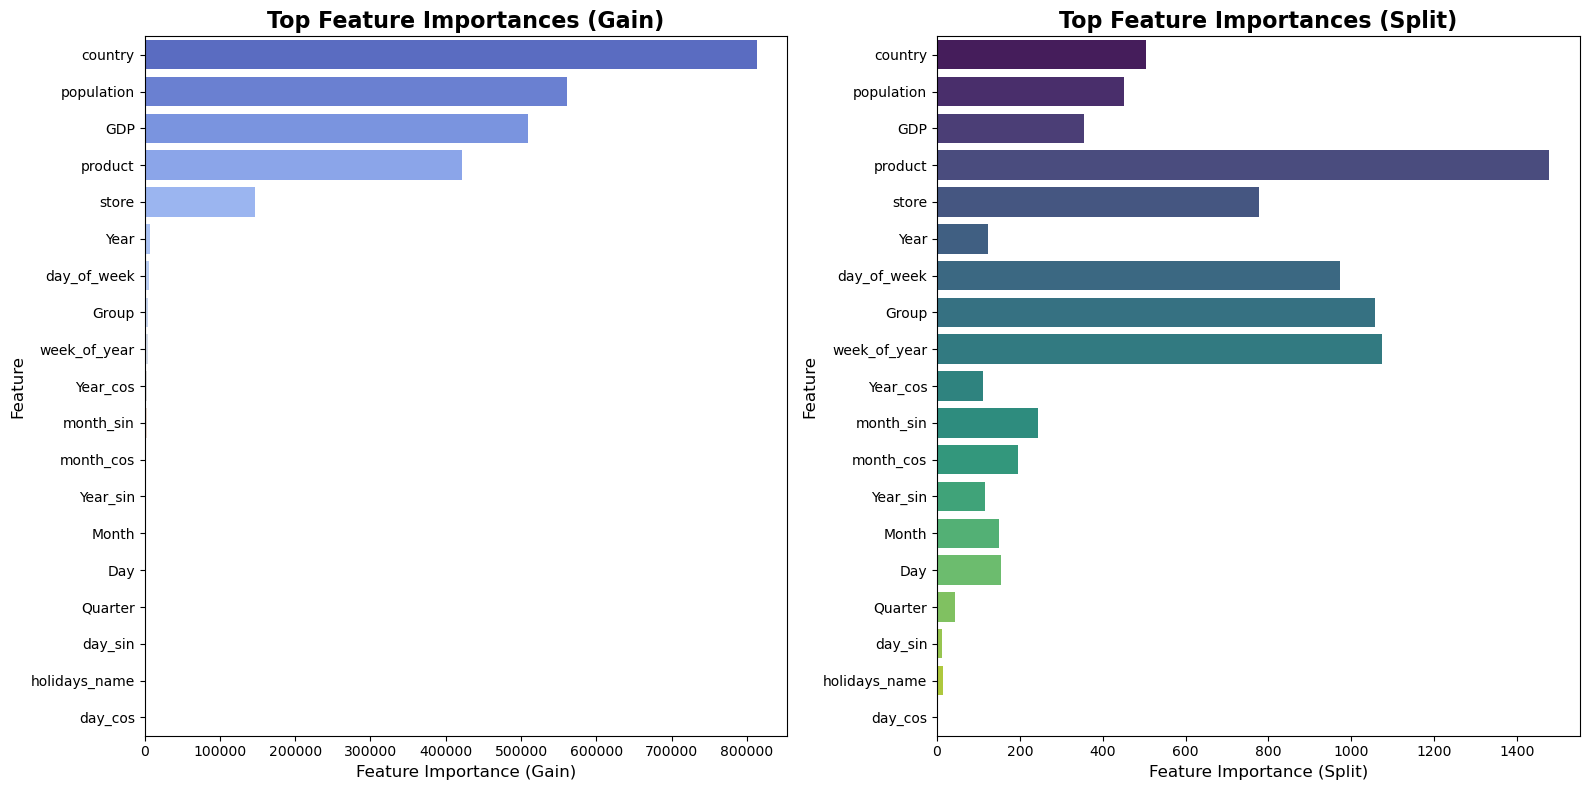

In [92]:
feature_names = models_lgb[0].booster_.feature_name()

importances_gain = np.zeros(len(feature_names)) 
importances_split = np.zeros(len(feature_names))  

for model in models_lgb:
    importances_gain += model.booster_.feature_importance(importance_type='gain')
    importances_split += model.booster_.feature_importance(importance_type='split')

importances_gain /= len(models_lgb)
importances_split /= len(models_lgb)
 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': importances_gain,
    'Split': importances_split
})

importance_df = importance_df.sort_values(by='Gain', ascending=False).reset_index(drop=True)
top_features = importance_df

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
plt.subplots_adjust(wspace=0.4) 

sns.barplot(data=top_features, x='Gain', y='Feature', ax=axes[0], palette="coolwarm")
axes[0].set_title("Top Feature Importances (Gain)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Feature Importance (Gain)", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)

sns.barplot(data=top_features, x='Split', y='Feature', ax=axes[1], palette="viridis")
axes[1].set_title("Top Feature Importances (Split)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Feature Importance (Split)", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

In [93]:
y_preds = np.expm1(lgbm_preds).astype(int)

In [94]:
submission = pd.DataFrame({'id': test_df['id'], 'num_sold': y_preds})
submission.to_csv('./submissions/submission.csv', index=False)
print(submission.shape)

(98550, 2)


In [95]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test,feature_names=X_test.columns.tolist(), max_display=20,show=False)
# plt.title('SHAP Summary Plot')
# plt.xlabel('SHAP value (impact on model output)')
# plt.rcParams['font.size']=12
# plt.show()